# Importing Libraries

In [1]:
!pip install opencv-python


In [2]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

C:\Users\AMAL P\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\AMAL P\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\AMAL P\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Parameters

In [3]:
target_classes = ['go', 'stop', 'warning']
color_map = {'go':'green', 'stop':'red', 'warning':'yellow'}
rgb_color_map = {'go': (0, 255, 0), 'stop': (255, 0, 0), 'warning': (255, 255, 0)}

train_folder_list = [
    'dayTrain',
#     'daySequence1',
#     'daySequence2',
#     'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 1000

# Load Dataset

In [4]:
def get_annotarion_dataframe(train_data_folders):
    data_base_path = "D:/Project_data/Lisa Dataset/"
    annotation_list = list()
    for folder in [folder + '/' for folder in train_data_folders if os.listdir(data_base_path)]:
        annotation_path = ''
        if 'sample' not in folder:
            annotation_path = data_base_path + 'Annotations/Annotations/' + folder
        else:
            annotation_path = data_base_path + folder*2
        image_frame_path = data_base_path + folder*2
        
        df = pd.DataFrame()
        if 'Clip' in os.listdir(annotation_path)[0]:
            clip_list = os.listdir(annotation_path)
            for clip_folder in clip_list:
                df = pd.read_csv(annotation_path + clip_folder +  '/frameAnnotationsBOX.csv', sep=";")
                df['image_path'] = image_frame_path + clip_folder + '/frames/'
                annotation_list.append(df)
        else:
            df = pd.read_csv(annotation_path +  'frameAnnotationsBOX.csv', sep=";")
            df['image_path'] = image_frame_path + 'frames/'
            annotation_list.append(df)
        
    df = pd.concat(annotation_list)
    df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
    df.columns = ['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path']
    df = df[df['target'].isin(target_classes)]
    df['filename'] = df['filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

In [5]:
train_annotation_df = get_annotarion_dataframe(train_folder_list)

target_classes = train_annotation_df['target'].unique()
target_classes.sort()

train_annotation_df

filename target    x1   y1    x2   y2  \
0      dayClip1--00000.jpg     go   698  333   710  358   
1      dayClip1--00000.jpg     go   846  391   858  411   
2      dayClip1--00001.jpg     go   698  337   710  357   
3      dayClip1--00001.jpg     go   847  390   859  410   
4      dayClip1--00002.jpg     go   698  331   710  356   
...                    ...    ...   ...  ...   ...  ...   
29693  dayClip9--00906.jpg     go  1139  157  1187  232   
29694  dayClip9--00907.jpg     go  1159  153  1204  233   
29695  dayClip9--00908.jpg     go  1185  150  1224  230   
29696  dayClip9--00909.jpg     go  1199  141  1256  226   
29697  dayClip9--00910.jpg     go  1231  126  1280  226   

                                              image_path  
0      D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
1      D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
2      D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
3      D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
4      D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
...                                                  ...  
29693  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
29694  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
29695  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
29696  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  
29697  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...  

[29698 rows x 7 columns]

target
stop       15113
go         13830
warning      755
Name: count, dtype: int64

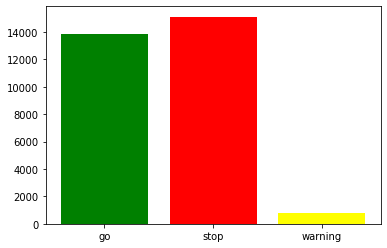

In [6]:
index, counts = np.unique(train_annotation_df['target'], return_counts=True)
colors = [color_map[target] for target in index]
plt.bar(index, counts, color=colors);
train_annotation_df['target'].value_counts()

In [7]:
train_annotation_df['target'].value_counts(normalize=True)

target
stop       0.508889
go         0.465688
warning    0.025423
Name: proportion, dtype: float64

## Resample (undersampling )

In [8]:
def resample_dataset(annotation_df, n_samples):
    df_resample_list = list()
    for target in target_classes:
        df = annotation_df[annotation_df['target'] == target].copy()
        df_r = resample(df, n_samples=n_samples, random_state=42)
        df_resample_list.append(df_r)
    return pd.concat(df_resample_list).reset_index(drop=True)

train_annotation_df = resample_dataset(train_annotation_df, n_samples_per_class)

target
go         1000
stop       1000
warning    1000
Name: count, dtype: int64

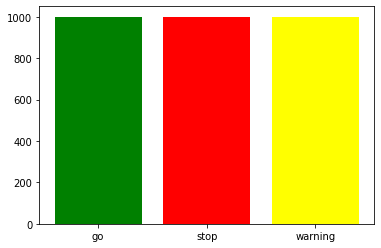

In [9]:
index, counts = np.unique(train_annotation_df['target'], return_counts=True)
colors = [color_map[target] for target in index]
plt.bar(index, counts, color=colors);
train_annotation_df['target'].value_counts()

# Pre-processing

## Extract semaphore from images

In [10]:
def image_traffic_light_crop(df):
    print("Cutting out traffic signs...")
    img_values = dict()
    for index, row in tqdm(df.iterrows(), total=len(df)):
        image_path = row["image_path"]
        filename = row["filename"]
        target = row["target"]
        x1, x2, y1, y2 = row["x1"], row["x2"], row["y1"], row["y2"]
        img = cv2.imread(image_path + filename)
        cropped_img = img[y1:y2, x1:x2]
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        img_values[index] = cropped_img
    return img_values

img_values = image_traffic_light_crop(train_annotation_df)

Cutting out traffic signs...


  0%|          | 0/3000 [00:00<?, ?it/s]

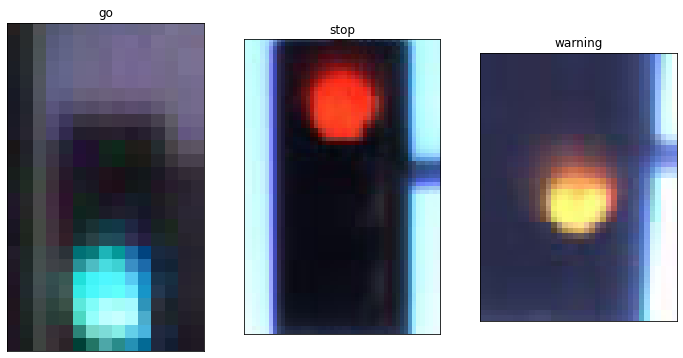

In [11]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = img_values[index]
    samples_imgs[target] = img

_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target])
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

## Binarize images

In [12]:
def image_binarization(img_values):
    print("Binarizing images...")
    binary_img_values = dict()
    for index in tqdm(img_values, total=len(img_values)):
        img = img_values[index]
        img = cv2.resize(img, (30, 50))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, binary_img = cv2.threshold(gray, 0, 255, 
                                      cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        binary_img[binary_img == 0] = 1
        binary_img[binary_img == 255] = 0
        binary_img_values[index] = binary_img
    return binary_img_values

binary_img_values = image_binarization(img_values)

Binarizing images...


  0%|          | 0/3000 [00:00<?, ?it/s]

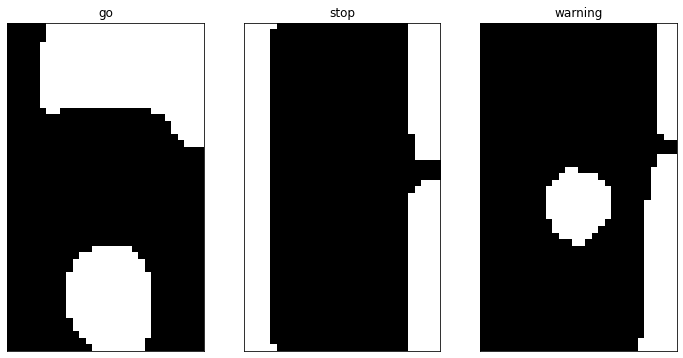

In [13]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = binary_img_values[index]
    samples_imgs[target] = img

_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target], cmap='gray')
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

## Convert image to vector

In [14]:
def image_to_vector(binary_img_values, annotation_df):
    print("Converting images to vector...")
    binary_img_vectors = dict()
    for index in tqdm(binary_img_values, total=len(binary_img_values)):
        img = binary_img_values[index]
        img_vector = np.c_[img.ravel()].transpose()[0]
        binary_img_vectors[index] = img_vector

    img_columns = ["p"+str(i) for i in range(1,1501)]
    df_img_values = pd.DataFrame(binary_img_vectors.values(), 
                                 index=binary_img_vectors.keys(), 
                                 columns=img_columns)
    return pd.merge(annotation_df, df_img_values, left_index=True, right_index=True)

df_img_values = image_to_vector(binary_img_values, train_annotation_df)
df_img_values.head()

Converting images to vector...


  0%|          | 0/3000 [00:00<?, ?it/s]

filename target    x1   y1    x2   y2  \
0  dayClip5--00296.jpg     go   675  359   690  384   
1  dayClip1--01560.jpg     go   660  322   672  342   
2  dayClip2--00691.jpg     go   842  129   884  209   
3  dayClip8--01037.jpg     go  1187  268  1238  318   
4  dayClip2--00317.jpg     go  1248  337  1275  382   

                                          image_path  p1  p2  p3  ...  p1491  \
0  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...   0   0   0  ...      1   
1  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...   0   0   0  ...      0   
2  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...   1   1   1  ...      1   
3  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...   0   0   0  ...      0   
4  D:/Project_data/Lisa Dataset/dayTrain/dayTrain...   0   0   0  ...      0   

   p1492  p1493  p1494  p1495  p1496  p1497  p1498  p1499  p1500  
0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0  
2      1      1      1      1      1      1      1      1      1  
3      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0  

[5 rows x 1507 columns]

## Definition of features and target

In [15]:
X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

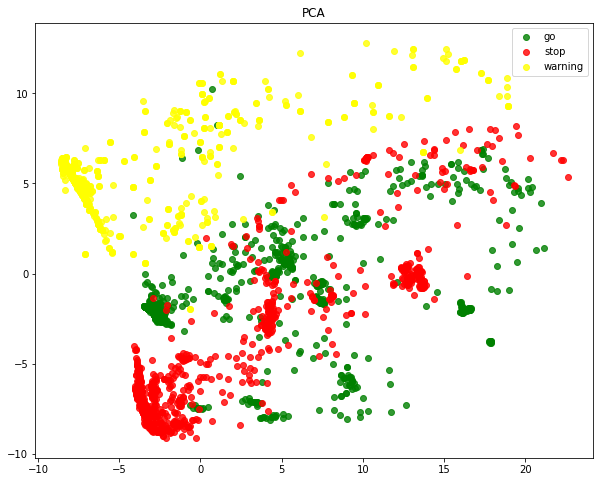

In [16]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)
y_r = pd.Series(y.values.ravel())

plt.figure(figsize=(10,8))
for target in target_classes:
    plt.scatter(X_r[y_r == target, 0], 
                X_r[y_r == target, 1], 
                color=color_map[target], alpha=.8, label=target)
plt.legend(loc="best")
plt.title('PCA')
plt.show()

# Training

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## Decision Tree Classifier

In [18]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train.values.ravel());

y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          go       0.98      0.99      0.98       250
        stop       1.00      0.98      0.99       250
     warning       0.99      1.00      0.99       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



## Logistic Regression

In [19]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train.values.ravel());

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          go       1.00      0.98      0.99       250
        stop       0.99      1.00      0.99       250
     warning       0.99      1.00      0.99       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



## SVM

In [20]:
svc = SVC()
svc.fit(X_train, y_train.values.ravel());

y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          go       0.99      0.99      0.99       250
        stop       1.00      0.98      0.99       250
     warning       0.99      1.00      0.99       250

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



# Test with another dataset

In [21]:
test_folder_list = [
#     'dayTrain',
    'daySequence1',
    'daySequence2',
    'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 100

test_annotation_df = get_annotarion_dataframe(test_folder_list)
test_annotation_df = resample_dataset(test_annotation_df, n_samples_per_class)
img_values = image_traffic_light_crop(test_annotation_df)
binary_img_values = image_binarization(img_values)
df_img_values = image_to_vector(binary_img_values, test_annotation_df)

X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

y_pred = svc.predict(X)
print(classification_report(y, y_pred))
df_img_values['pred_target'] = y_pred

Cutting out traffic signs...


  0%|          | 0/300 [00:00<?, ?it/s]

Binarizing images...


  0%|          | 0/300 [00:00<?, ?it/s]

Converting images to vector...


  0%|          | 0/300 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          go       0.88      0.85      0.86       100
        stop       0.85      0.97      0.91       100
     warning       0.99      0.88      0.93       100

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



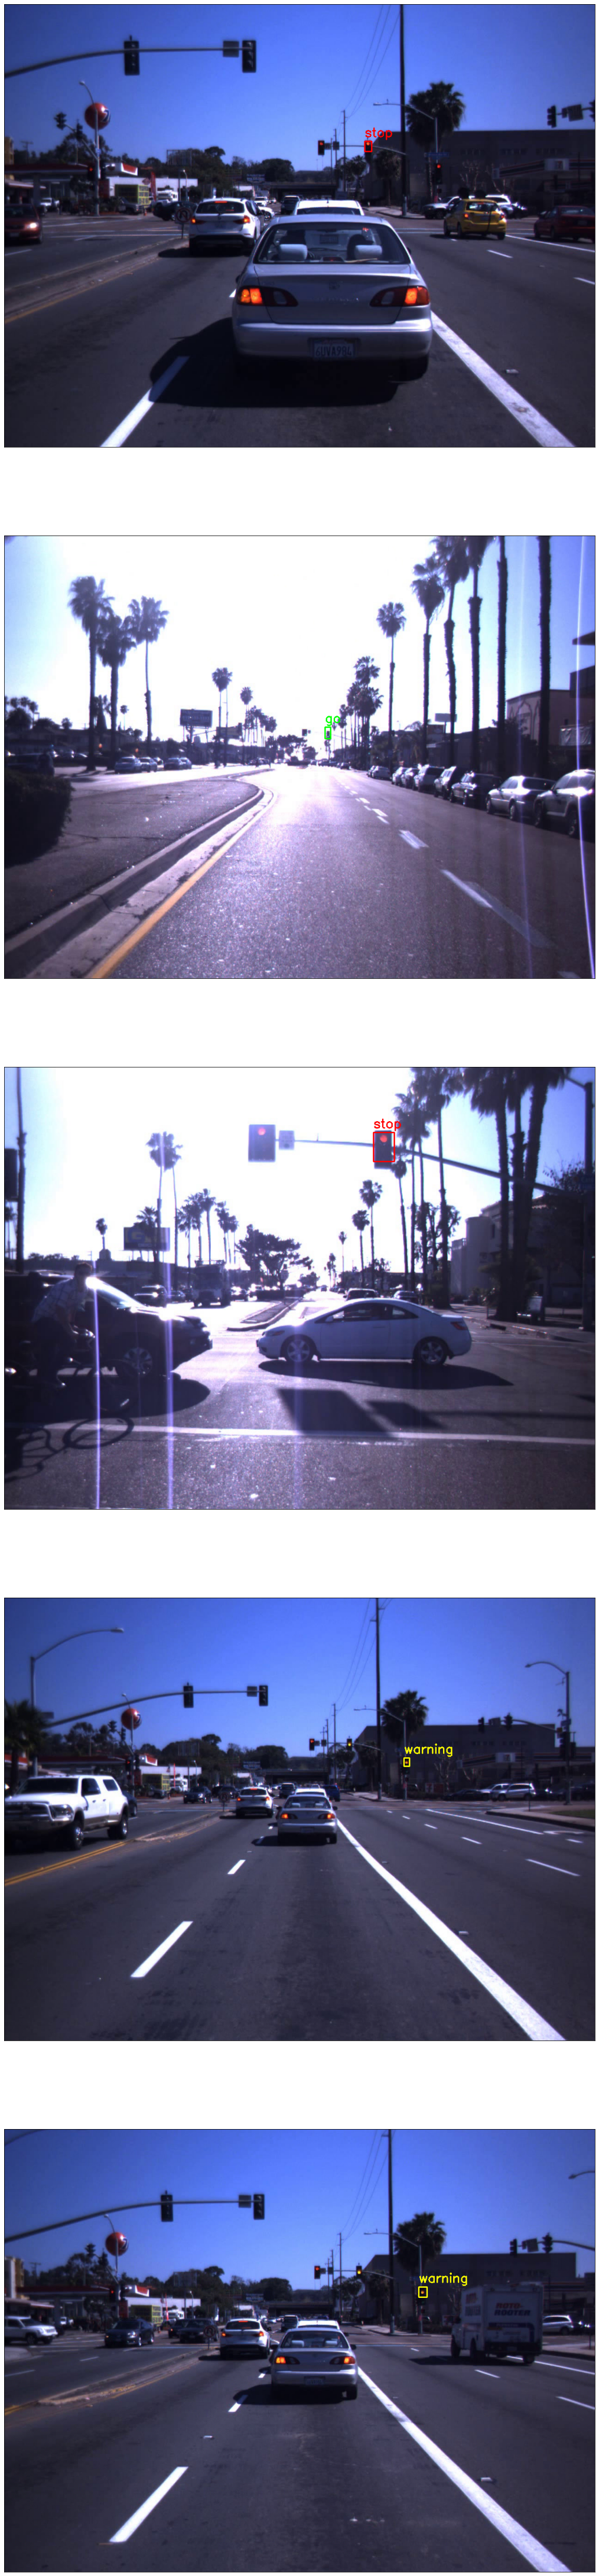

In [22]:
def show_image_with_label(df_sample, img_list):
    n_imgs = len(img_list)
    _, axs = plt.subplots(n_imgs, 1, figsize=(20*n_imgs, 16*n_imgs))
#     axs = axs.flatten()
    for filename, ax in zip(img_list, axs):
        df = df_sample[df_sample['filename'] == filename].copy()
        image_path = df['image_path'].values[0]
        img = cv2.imread(image_path + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for _, row in df.iterrows():
            target = row['pred_target']
            x1, x2, y1, y2 = row['x1'], row['x2'], row['y1'], row['y2']
            start_point = (x1, y1)
            end_point = (x2, y2)
            color = rgb_color_map[target]
            thickness = 2
            img = cv2.rectangle(img, start_point, end_point, color, thickness)
            img = cv2.putText(img, target, (x1, y1-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.show()
    
sample_img_list = df_img_values['filename'].sample(5).values
show_image_with_label(df_img_values, sample_img_list)

In [23]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
conf_matrix




array([[85, 14,  1],
       [ 3, 97,  0],
       [ 9,  3, 88]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

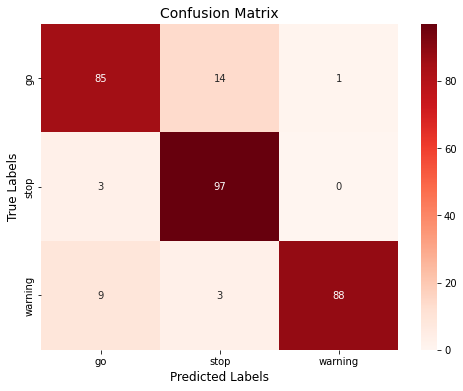

In [24]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=target_classes, yticklabels=target_classes)

# Set x-axis and y-axis labels
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)



In [29]:
detection_counts=[]
for i in range(0,3):
    detection_counts.append(conf_matrix[i,i])
detection_counts

[85, 97, 88]

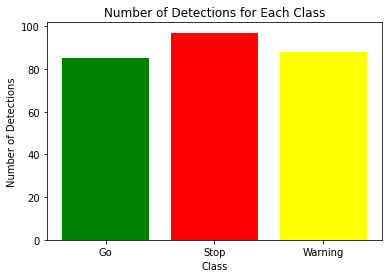

In [32]:
class_names = ['Go', 'Stop', 'Warning']

# Create a DataFrame from the data
df = pd.DataFrame({'Class': class_names, 'Detections': detection_counts})

# Plot a bar graph
plt.bar(df['Class'], df['Detections'], color=['green', 'red', 'yellow'])
plt.xlabel('Class')
plt.ylabel('Number of Detections')
plt.title('Number of Detections for Each Class')
plt.show()